In [2]:
import cv2 as cv
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom as dicom
import glob
import mritopng
import tensorflow.compat.v1 as tf #tf v2는 아직 불안정
tf.disable_v2_behavior() 

from numpy import expand_dims
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics

In [3]:
# 데이터 경로
PathDicom = "C:/Users/codls/Desktop/dcm/1/"

# 데이터들 빈 list에 저장
lstFilesDCM = []  
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".ima" in filename.lower():  # 폴더에 .ima 파일이 있으면 리스트에 추가
            lstFilesDCM.append(os.path.join(dirName,filename))

In [4]:
RefDs = pydicom.read_file(lstFilesDCM[0])
ConstPixelDims = (len(lstFilesDCM),int(RefDs.Rows), int(RefDs.Columns))

# The array is sized based on 'ConstPixelDims'
ArrayDicom1 = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
#ArrayDicom1 = np.zeros(ConstPixelDims, dtype=np.uint16) 

print(ArrayDicom1.shape)
# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # 파일 읽기
    ds = pydicom.read_file(filenameDCM)
    # array 형태로 저장
    ArrayDicom1[lstFilesDCM.index(filenameDCM),:,:] = ds.pixel_array  

(192, 256, 256)


In [5]:
print(lstFilesDCM[26]) # 확인

C:/Users/codls/Desktop/dcm/1/PIG_HIFU.MR.DGMIF_BBB.0004.0027.2019.12.19.12.25.49.826651.75831877.IMA


In [6]:
RefDs.pixel_array.dtype

dtype('uint16')

In [7]:
lstFilesDCM[26][:-4]

'C:/Users/codls/Desktop/dcm/1/PIG_HIFU.MR.DGMIF_BBB.0004.0027.2019.12.19.12.25.49.826651.75831877'

In [8]:
# png 파일로 저장
mritopng.convert_file(lstFilesDCM[26], lstFilesDCM[26][:-4]+".png")

Removing existing output file C:/Users/codls/Desktop/dcm/1/PIG_HIFU.MR.DGMIF_BBB.0004.0027.2019.12.19.12.25.49.826651.75831877.png


In [9]:
src = cv.imread(lstFilesDCM[26][:-4]+".png",-1)

In [10]:
type(src)
src.dtype

dtype('uint8')

dtype('uint16')

<Figure size 432x288 with 0 Axes>

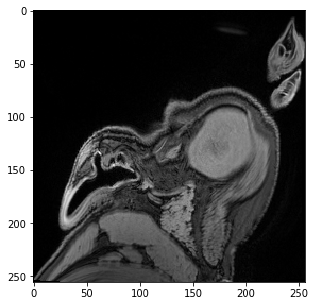

In [11]:
# 29번째 slice display
plt.set_cmap(plt.gray());
plt.figure(figsize = (5,5));
plt.imshow(ArrayDicom1[26,:,:]);
ArrayDicom1.dtype

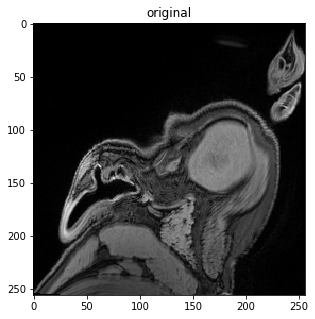

In [12]:
plt.figure(figsize = (5,5));
plt.imshow(src, cmap = 'gray'); # cmap는 gray이미지를 확립
plt.title('original');

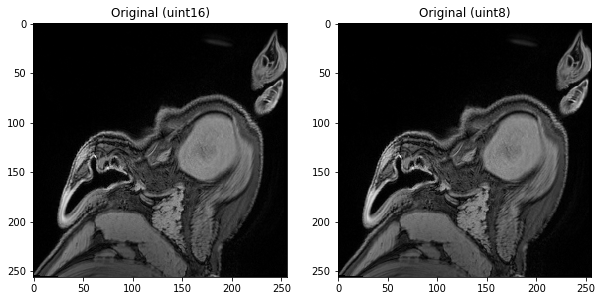

In [13]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1);
plt.imshow(ArrayDicom1[26,:,:], cmap = 'gray');
plt.title('Original (uint16)');

plt.subplot(1,2,2);
plt.imshow(src, cmap = 'gray');
plt.title('Original (uint8)');

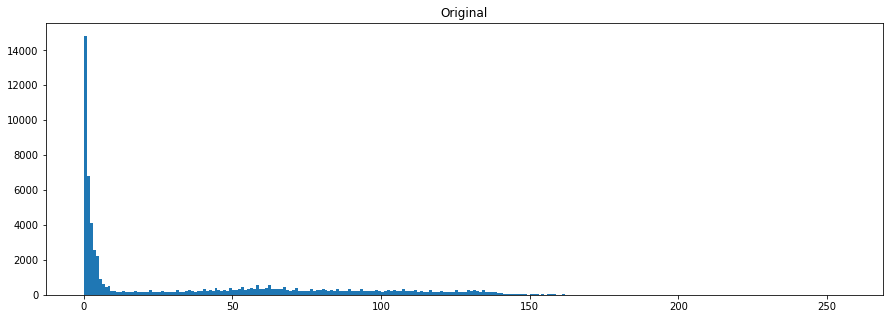

In [14]:
plt.figure(figsize=(15, 5))
plt.title('Original')
plt.hist(src.ravel(), 256, [0, 256])
plt.show();

In [15]:
## 유의미한 2 peak를 찾지 못함

In [16]:
# (1) Adaptive Threshold
# Threshold 경계선 찾기
## Binary는 임의의 값
ret, thr = cv.threshold(src,80,255,
                           cv.THRESH_BINARY_INV)

thr2 = cv.adaptiveThreshold(src, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                     cv.THRESH_BINARY, 5, 2)

thr3 = cv.adaptiveThreshold(src, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv.THRESH_BINARY, 5, 2) 

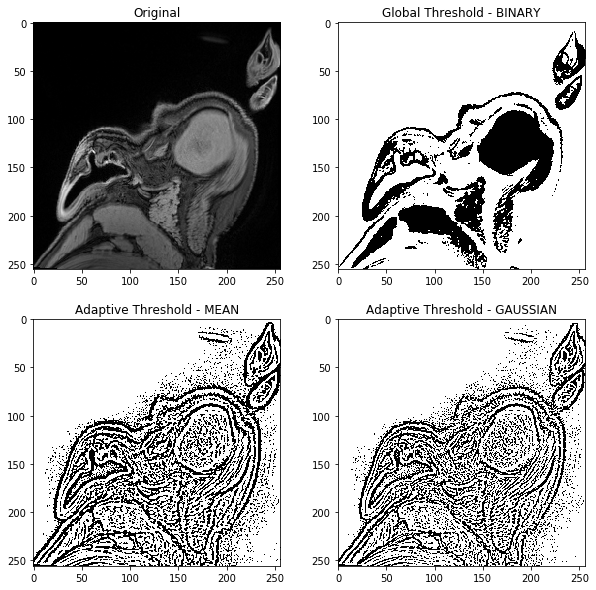

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1);
plt.imshow(src, cmap = 'gray');
plt.title('Original');

plt.subplot(2,2,2);
plt.imshow(thr, cmap = 'gray');
plt.title('Global Threshold - BINARY');

plt.subplot(2,2,3);
plt.imshow(thr2, cmap = 'gray');
plt.title('Adaptive Threshold - MEAN');

plt.subplot(2,2,4);
plt.imshow(thr3, cmap = 'gray');
plt.title('Adaptive Threshold - GAUSSIAN');

In [18]:
# 노이즈 제거를 위해 색 반전
dst = cv.bitwise_not(thr2)

In [19]:
# 노이즈 제거 위해
kernel = np.ones((2,1),np.uint8)

opening = cv.morphologyEx(dst, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(dst, cv.MORPH_CLOSE, kernel)

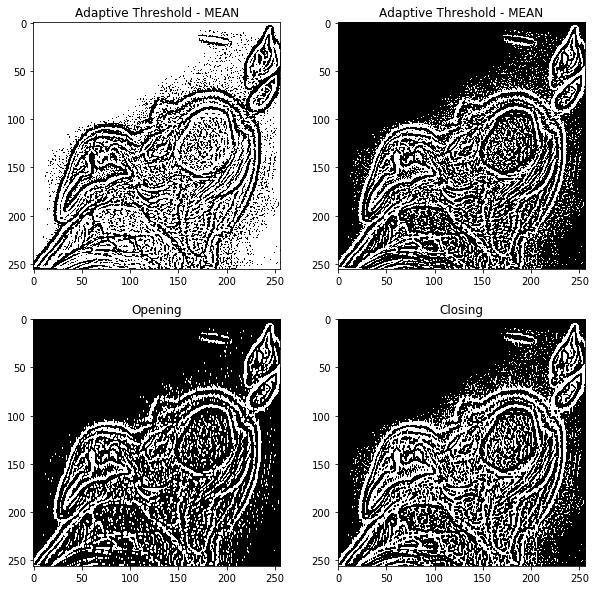

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1);
plt.imshow(thr2, cmap = 'gray');
plt.title('Adaptive Threshold - MEAN');

plt.subplot(2,2,2);
plt.imshow(dst, cmap = 'gray');
plt.title('Adaptive Threshold - MEAN');

plt.subplot(2,2,3);
plt.imshow(opening, cmap = 'gray');
plt.title('Opening');

plt.subplot(2,2,4);
plt.imshow(closing, cmap = 'gray');
plt.title('Closing');

In [21]:
# 2) OTSU 필터
ret4, thr4 = cv.threshold(src,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

In [22]:
# OTSU 필터에 노이즈 제거, 흰색 배경 메꾸기
kernel = np.ones((3,2),np.uint8)
opening = cv.morphologyEx(thr4,cv.MORPH_OPEN,kernel,iterations=2)

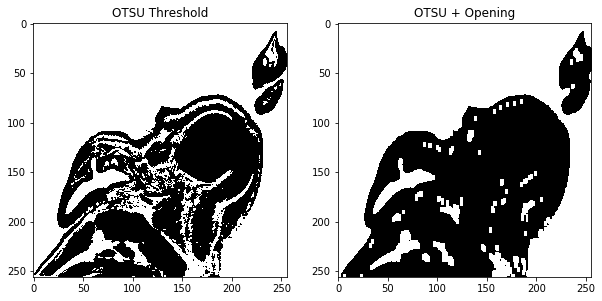

In [23]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1);
plt.imshow(thr4, cmap = 'gray');
plt.title('OTSU Threshold');

plt.subplot(1,2,2);
plt.imshow(opening, cmap = 'gray');
plt.title('OTSU + Opening');

In [24]:
#src_copy = src
src_copy = cv.cvtColor(src, cv.COLOR_GRAY2BGR) # edge 따기
src_copy2 = cv.cvtColor(src, cv.COLOR_GRAY2BGR) # 사각형 타겟
src_copy3 = cv.cvtColor(src, cv.COLOR_GRAY2BGR) # target
src_copy4 = cv.cvtColor(src, cv.COLOR_GRAY2BGR) # segment

In [25]:
# contour 후 원본 이미지에 합성
contours, hierachy = cv.findContours(opening, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img_origin = cv.drawContours(src_copy, contours, -1, (0, 255, 0), 2)

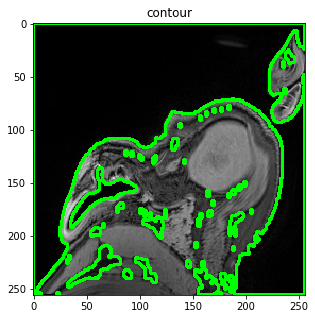

In [26]:
plt.figure(figsize = (5,5));
plt.imshow(img_origin);
plt.title('contour');

In [27]:
# 좌표 위치 저장할 빈 리스트 생성
x_li = []
y_li = []
xw_li = []
yh_li = []
w_li = []
h_li = []

for contour in contours:
        x, y, w, h = cv.boundingRect(contour)  # 좌상단 꼭지점 좌표 , width, height
        
        x_li.append(x)
        y_li.append(y)
        xw_li.append(x+w)
        yh_li.append(y+h)
        w_li.append(w)
        h_li.append(h)
        
        cv.rectangle(src_copy2, (x, y), (x+w, y+h), (0, 255, 0), 2) 

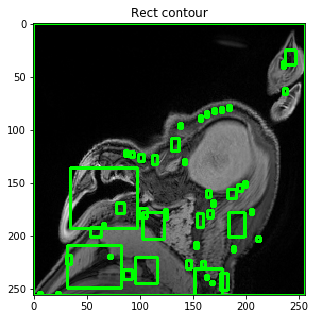

In [28]:
plt.figure(figsize = (5,5));
plt.imshow(src_copy2,cmap = 'gray');
plt.title('Rect contour');

In [29]:
w_li.index(256)

46

In [30]:
## (임시)w 길이 중 전체 길이를 제외하고 가장 큰 값 찾기
w_li.remove(256)

In [31]:
# max 값과 요소 위치 찾기
print(max(w_li))
num = w_li.index(max(w_li))

63


In [32]:
cv.rectangle(src_copy3, (x_li[num], y_li[num]), (xw_li[num], yh_li[num]),
             (0, 255, 0), 2); 

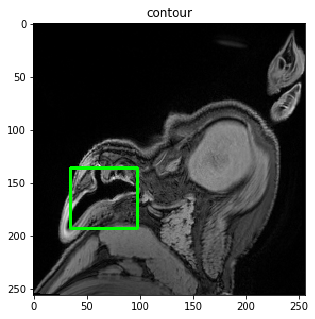

In [33]:
plt.figure(figsize = (5,5));
plt.imshow(src_copy3,cmap = 'gray');
plt.title('contour');

In [34]:
## 임시 좌표
image_crop = src_copy4[y_li[num]-5: yh_li[num]+5,x_li[num]-5:xw_li[num]+5] # User
image_crop2 = src_copy4[y_li[num]: yh_li[num],x_li[num]:xw_li[num]] # Original

In [35]:
image_crop.shape

(67, 73, 3)

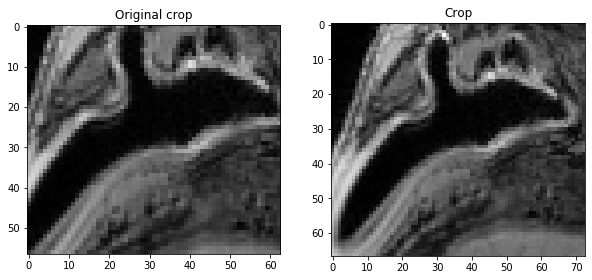

In [36]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1);
plt.imshow(image_crop2, cmap = 'gray');
plt.title('Original crop');

plt.subplot(1,2,2);
plt.imshow(image_crop, cmap = 'gray');
plt.title('Crop');

In [37]:
# User crop
image_crop3 = image_crop

In [38]:
samples = expand_dims(image_crop, 0) 
samples2 = samples

In [39]:
# 이미지 변형(ImageDataGenerator)
datagen = ImageDataGenerator(
                            #zoom_range=[0.5,0.5], # zoom 범위 : 0.5~1 
                            #brightness_range=[0.2,1.0], # 밝기 0.2~1
                            rotation_range=5, # 회전
                            #horizontal_flip=True, #수평 대칭 이미지
                            #vertical_flip = True, #수직 대칭 이미지
                            height_shift_range=0.0005, #위로 이동
                            width_shift_range=0.0005,#아래로 이동
                            fill_mode = 'nearest') 

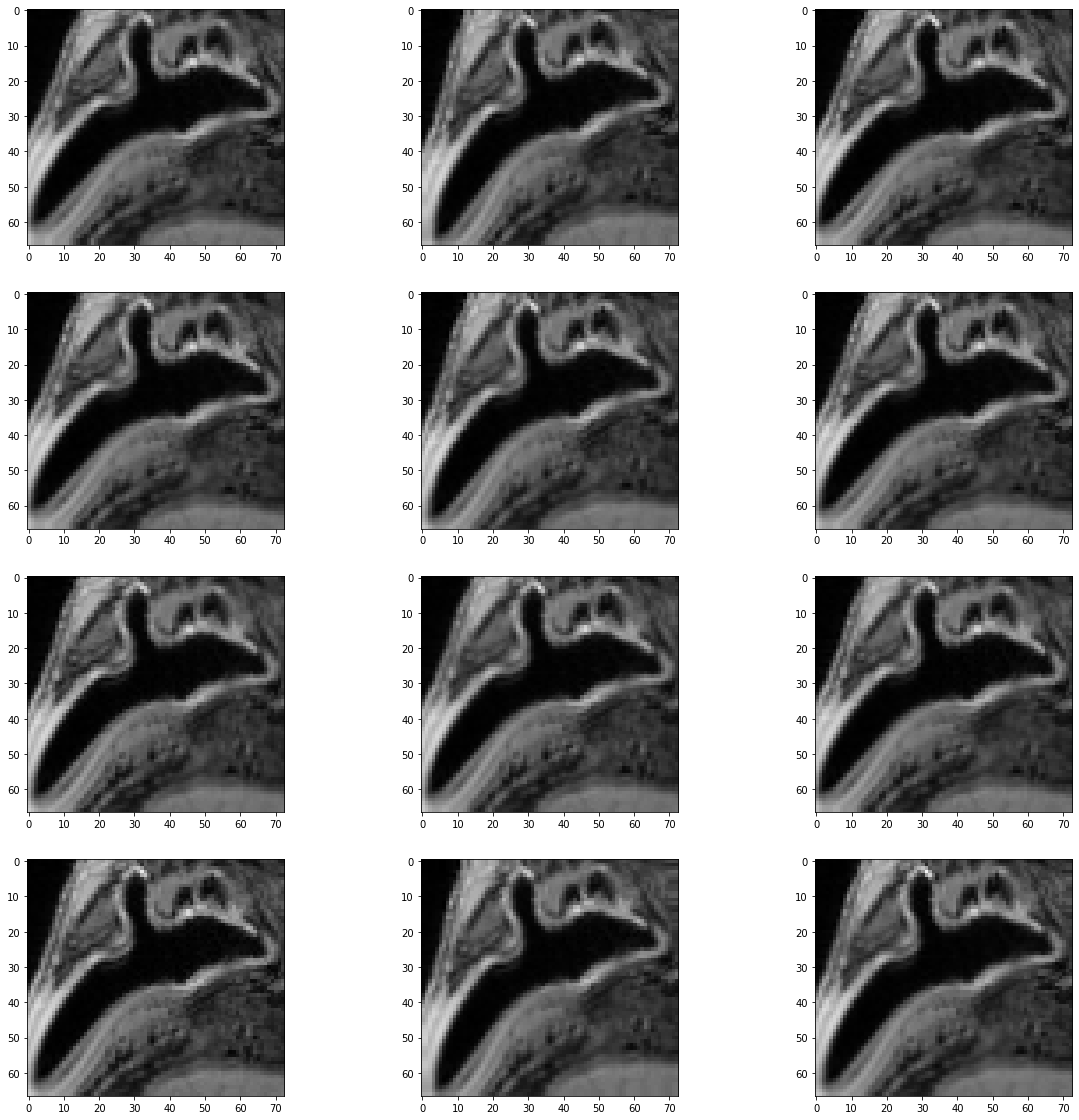

In [155]:
######## 1개만
it = datagen.flow(samples, batch_size=1)

# figure size 정하기
fig = plt.figure(figsize = (20,20))

for i in range(12):
    # subplot 배치
    plt.subplot(4, 3, 1 + i)
    # 값을 차례대로 꺼냄
    batch = it.next()
    # 1차원의 출력 이미지, type을 unit8로 해줌 
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()

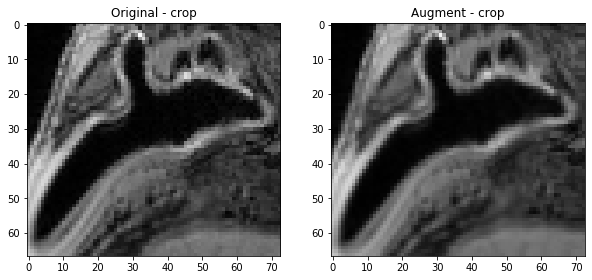

In [156]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1);
plt.imshow(image_crop, cmap = 'gray');
plt.title('Original - crop');

plt.subplot(1,2,2);
plt.imshow(image, cmap = 'gray');
plt.title('Augment - crop');

In [175]:
i = 0
j = 0

In [176]:
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        src_copy4[y_li[num]-5+i][x_li[num]-5+j] = image[i][j]

Text(0.5, 1.0, 'Target Augment')

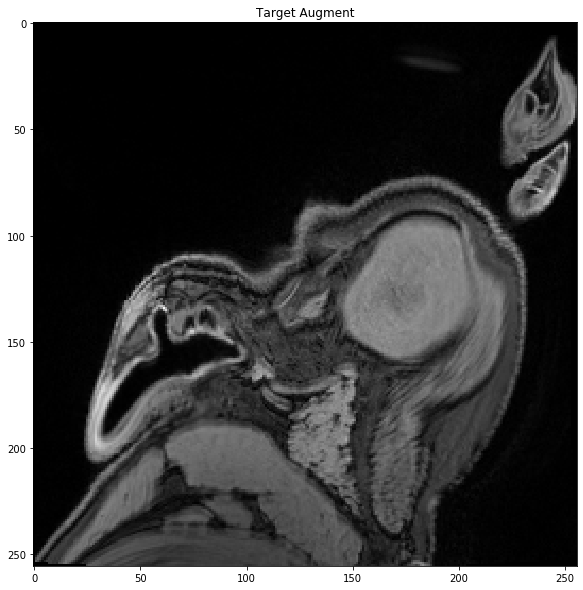

In [171]:
plt.figure(figsize = (10,10));
plt.imshow(src_copy4);
plt.title('Target Augment')

In [294]:
######## 여러개
i = 0
j = 0
k = 0

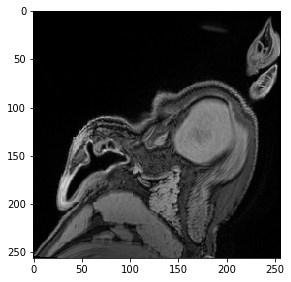

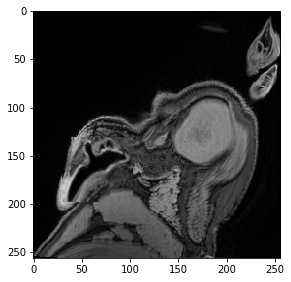

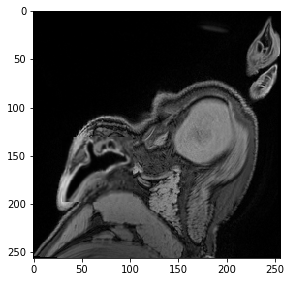

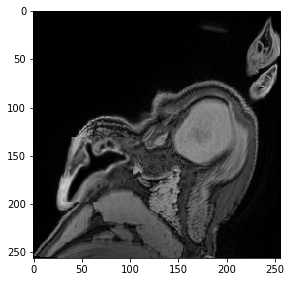

In [295]:
for i in range(4):
    it = datagen.flow(samples2, batch_size=1)
    batch = it.next()
    image = batch[0]
    
    
    
    for j in range(image.shape[0]):
        for k in range(image.shape[1]):
            src_copy4[y_li[num]-5+j][x_li[num]-5+k] = image[j][k]
            
    plt.figure(figsize = (10,10))               
    plt.subplot(2, 2, 1 + i)
    plt.imshow(src_copy4)
    

In [41]:
# 이미지 변형(ImageDataGenerator)
datagen_a = ImageDataGenerator(
                            #zoom_range=[0.5,0.5], # zoom 범위 : 0.5~1 
                            #brightness_range=[0.2,1.0], # 밝기 0.2~1
                            rotation_range=5, # 회전
                            #horizontal_flip=True, #수평 대칭 이미지
                            #vertical_flip = True, #수직 대칭 이미지
                            height_shift_range=0.0005, #위로 이동
                            width_shift_range=0.0005,#아래로 이동
                            fill_mode = 'nearest') 

In [42]:
# 이미지 변형(ImageDataGenerator)
datagen = ImageDataGenerator(
                            #zoom_range=[0.5,0.5], # zoom 범위 : 0.5~1 
                            #brightness_range=[0.2,1.0], # 밝기 0.2~1
                            rotation_range=5, # 회전
                            #horizontal_flip=True, #수평 대칭 이미지
                            #vertical_flip = True, #수직 대칭 이미지
                            height_shift_range=0.0005, #위로 이동
                            width_shift_range=0.0005,#아래로 이동
                            fill_mode = 'nearest') 

In [43]:
# 저장하는법?

In [44]:
src_copy4.shape
src_copy5 = src_copy4

In [45]:
batches = 0
for i in range(5):
    it = datagen.flow(samples2, batch_size=1)
    batch = it.next()
    image = batch[0]
    
    for j in range(image.shape[0]):
        for k in range(image.shape[1]):
            src_copy4[y_li[num]-5+j][x_li[num]-5+k] = image[j][k]
            
    src_copy5 = src_copy4.reshape((1,)+src_copy4.shape)
    
    for l in datagen_a.flow(src_copy5,y=None, batch_size=1,
                   shuffle = False, sample_weight = None,
                   seed = None, save_to_dir="C:/Users/codls/Desktop/save",
                   save_prefix=i, save_format='png'):
        batches += 1
        if batches >= 5:
            break
        
                    
    #for batcha in datagen_a.flow(src_copy5, batcha_size=1,
                                  #save_to_dir="C:/Users/codls/Desktop/save", save_prefix=l, save_format='png'):
                    
    #plt.subplot(2, 2, 1 + i)
    #plt.imshow(src_copy4)
    

In [2]:
train_datagen = ImageDataGenerator(
                      rescale=1./255,
                      horizontal_flip=True, # 수평 대칭 이미지를 50% 확률로 만들어 추가
                      width_shift_range=0.1, # 전체 크기의 10% 범위에서 좌우로 이동
                      height_shift_range=0.1, # 마찬가지로 위, 아래로 이동
                      fill_mode='nearest'
                       )

train_generator = train_datagen.flow_from_directory
                      ('/Users/user/Downloads/deeplearning/run_project/train', # 학습셋 폴더 위치
                      target_size=(150, 150),  # 이미지 크기
                      batch_size=5,
                      class_mode='binary')  # 치매/정상 2진 분류

# 테스트 셋은 정규화만 진행

test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory

                      ('C:/Users/user/Downloads/deeplearning/run_project/test', 

                      target_size=(150, 150),

                      batch_size=5,

                      class_mode='binary')
    

# CNN 모델 적용

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, (3, 3)))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3)))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(64))

model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2))

model.add(Activation('sigmoid'))

# 모델 컴파일

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 모델 실행

history = model.fit_generator   # fit이 아닌 fit_generator 인점 주의

                      (train_generator,  # 앞서 만든 train_generator 를 학습 모델로 사용

                      steps_per_epoch=100,  # 이미지 생성기에서 몇개의 샘플 뽑을지 결정

                      epochs=20,

                      validation_data=test_generator,  # 앞서 만든 test_generator 를 테스트 셋으로 사용

                      validation_steps=10)

# 결과 그래프로 표현

acc= history.history['accuracy']

val_acc= history.history['val_accuracy']

y_vloss = history.history['val_loss']

y_loss = history.history['loss']


x_len = np.arange(len(y_loss))


IndentationError: unexpected indent (<ipython-input-2-95728b07ec26>, line 10)

In [3]:
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')

plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')

plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')

plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')


plt.legend(loc='upper right')

plt.grid()

plt.xlabel('epoch')

plt.ylabel('loss/acc')

plt.show()

NameError: name 'x_len' is not defined